In [76]:
#coding=utf-8
import matplotlib
import matplotlib.pyplot as plt
import numpy as np  
import keras
from keras.models import Sequential  
from keras.layers import Conv2D,MaxPooling2D,UpSampling2D,BatchNormalization,Reshape,Permute,Activation,Input  
from keras.utils.np_utils import to_categorical  
from keras.preprocessing.image import img_to_array  
from keras.callbacks import ModelCheckpoint  
from sklearn.preprocessing import LabelEncoder  
from keras.models import Model
from keras.layers.merge import concatenate
from PIL import Image  
import matplotlib.pyplot as plt  
import cv2
import random
import os
from tqdm import tqdm  
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
seed = 7  
np.random.seed(seed)  

In [77]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}

    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))

    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))

    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        # acc
        plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
        # loss
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc="upper right")
        plt.show()
history=LossHistory()

In [78]:
label=cv2.imread(r"E:\project\images\images_part\ROI02label.tif",0)-1
print("label shape:",label.shape)

label shape: (400, 400)


In [79]:
image=cv2.imread(r"E:\project\images\images_part\040121_1665_1666part.tif")
print("image shape:",image.shape)

image shape: (400, 400, 3)


In [68]:
size=40
def generateData(image, label, num, size, save_path):
    height, width, channel = image.shape
    heights_ = np.random.randint(0, height-size, size=num)
    widths_ = np.random.randint(0, width-size, size=num)
    save_image = np.zeros_like((height, width, channel), dtype=np.uint8)
    save_label = np.zeros_like((height, width), dtype=np.uint8)
    i=0
    for height_ in heights_:
        for width_ in widths_:
            i+=1
            save_image = image[height_:height_+size, width_:width_+size, :]
            save_label = label[height_:height_+size, width_:width_+size]
            cv2.imwrite(os.path.join(save_path, "image\%d.jpg"%i), save_image)
            cv2.imwrite(os.path.join(save_path, "label\%d.jpg"%i), save_label)
    
generateData(image, label, 50, 32, r"E:\\project\images\images_part")

In [69]:
# building = [128,128,0]
# road = [128,64,128]
# veg = [0,240,0]
# water = [128,0,0]
# bareland = [256,256,256]

# COLOR_DICT = np.array([building,road,veg,water,bareland])

# def labelVisualize(num_class,color_dict,img):
#     img_out=np.zeros((img.shape[0],image.shape[1],3),dtype=np.uint8)
#     for i in range(num_class):
#         img_out[img == i] = color_dict[i]
#     return img_out

# def saveResult(save_path,image,flag_multi_class = False,num_class = 5):
#     img = labelVisualize(num_class,COLOR_DICT,image)
#     cv2.imwrite(os.path.join(save_path,"predict.png"),img)

In [82]:
img_w = size  
img_h = size
#有一个为背景  
#n_label = 4+1  
n_label = 5
  
classes = [0. ,  1.,  2.,   3.  , 4.]  
  
labelencoder = LabelEncoder()  
labelencoder.fit(classes)  

def load_img(path, grayscale=False):
    if grayscale:
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
    else:
        img = cv2.imread(path)
        img = np.array(img,dtype="float") / 255.0
    return img


filepath =r"E:\\project\images\images_part\\"

def get_train_val(val_rate = 0.25):
    train_url = []    
    train_set = []
    val_set  = []
    for pic in os.listdir(filepath + 'image'):
        train_url.append(pic)
    random.shuffle(train_url)
    total_num = len(train_url)
    val_num = int(val_rate * total_num)
    for i in range(len(train_url)):
        if i < val_num:
            val_set.append(train_url[i]) 
        else:
            train_set.append(train_url[i])
    return train_set,val_set

# data for training  
def generateData(batch_size,data=[]):  
    #print 'generateData...'
    while True:  
        train_data = []  
        train_label = []  
        batch = 0  
        for i in (range(len(data))): 
            url = data[i]
            batch += 1 
            img = load_img(filepath + 'image/' + url)
            img = img_to_array(img)  
            train_data.append(img)  
            label = load_img(filepath + 'label/' + url, grayscale=True) 
            label = img_to_array(label)
            train_label.append(label)  
            if batch % batch_size==0: 
                #print 'get enough bacth!\n'
                train_data = np.array(train_data)  
                train_label = np.array(train_label)  
                yield (train_data,train_label)  
                train_data = []  
                train_label = []  
                batch = 0  
 
# data for validation 
def generateValidData(batch_size,data=[]):  
    #print 'generateValidData...'
    while True:  
        valid_data = []  
        valid_label = []  
        batch = 0  
        for i in (range(len(data))):  
            url = data[i]
            batch += 1  
            img = load_img(filepath + 'image/' + url)
            img = img_to_array(img)  
            valid_data.append(img)  
            label = load_img(filepath + 'label/' + url, grayscale=True)
            label = img_to_array(label)
            valid_label.append(label)  
            if batch % batch_size==0:  
                valid_data = np.array(valid_data)  
                valid_label = np.array(valid_label)  
                yield (valid_data,valid_label)  
                valid_data = []  
                valid_label = []  
                batch = 0  
  
  
def unet():
    inputs = Input((img_w, img_h, 3))
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(input = inputs, output = conv10)
    model.summary()
    model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [84]:
EPOCHS = 30
BS = 16  
model = unet()  
callable = [history]  
train_set,val_set = get_train_val()
train_numb = len(train_set)  
valid_numb = len(val_set)  
print ("the number of train data is",train_numb)  
print ("the number of val data is",valid_numb)
H = model.fit_generator(generator=generateData(BS,train_set),steps_per_epoch=train_numb//BS,epochs=EPOCHS,verbose=1,  
                    validation_data=generateValidData(BS,val_set),validation_steps=valid_numb//BS,callbacks=callable,max_q_size=1)  


D:\Python37\lib\site-packages\ipykernel_launcher.py:131: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_35 (Conv2D)              (None, 32, 32, 64)   1792        input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, 32, 32, 64)   36928       conv2d_35[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_9 (MaxPooling2D)  (None, 16, 16, 64)   0           conv2d_36[0][0]                  
__________________________________________________________________________________________________
conv2d_37 

D:\Python37\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(generator=<generator..., steps_per_epoch=9, epochs=30, verbose=1, validation_data=<generator..., validation_steps=3, callbacks=[<__main__..., max_queue_size=1)`
  # This is added back by InteractiveShellApp.init_path()


Epoch 1/30
9/9 [==============================] - ETA: 1:38 - loss: 0.7182 - acc: 0.153 - ETA: 1:00 - loss: -0.0024 - acc: 0.11 - ETA: 44s - loss: -6.1917 - acc: 0.1120 - ETA: 33s - loss: -9.2710 - acc: 0.107 - ETA: 25s - loss: -9.6928 - acc: 0.102 - ETA: 18s - loss: -11.5665 - acc: 0.10 - ETA: 11s - loss: -12.4466 - acc: 0.09 - ETA: 5s - loss: -13.0495 - acc: 0.0942 - 53s 6s/step - loss: -13.6199 - acc: 0.0942 - val_loss: -15.1468 - val_acc: 0.1364
Epoch 2/30
8/9 [=========================>....] - ETA: 38s - loss: -16.1643 - acc: 0.12 - ETA: 33s - loss: -14.1311 - acc: 0.09 - ETA: 29s - loss: -16.0300 - acc: 0.10 - ETA: 25s - loss: -16.7282 - acc: 0.10 - ETA: 21s - loss: -15.6815 - acc: 0.09 - ETA: 15s - loss: -16.5571 - acc: 0.09 - ETA: 10s - loss: -16.7242 - acc: 0.09 - ETA: 5s - loss: -16.7924 - acc: 0.0907 

KeyboardInterrupt: 

In [44]:
test_loss,test_acc=model.evaluate(X_test,y_test)
print("test_acc:",test_acc)
print("test_loss:",test_loss)

32000/32000 [==============================] - 2s 67us/step
test_acc: 0.64675
test_loss: 0.8951879474520683


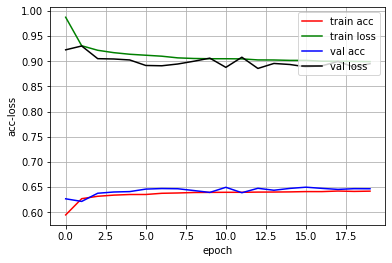

In [45]:
history.loss_plot('epoch')